In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from openparticle import ParticleOperator
import numpy as np
import cirq
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.rescale import bosonically_rescale_terms, get_numbers_of_bosonic_operators_in_terms, get_number_of_active_bosonic_modes
from src.lobe.system import System
from src.lobe.lcu import LCU
from colors import *
from cirq.contrib.svg import SVGCircuit
from openparticle import generate_matrix
from src.lobe._utils import get_basis_of_full_system
from src.lobe.bosonic import bosonic_mode_block_encoding, bosonic_mode_plus_hc_block_encoding
from src.lobe.fermionic import fermionic_product_block_encoding
from src.lobe.index import index_over_terms
from src.lobe.metrics import CircuitMetrics
from src.lobe._utils import get_exponents
from functools import partial

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-14 14:49:53,649	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


ImportError: cannot import name 'get_exponents' from 'src.lobe._utils' (/Users/williamsimon/Desktop/Research/SparseOracle/notebooks/../src/lobe/_utils.py)

In [15]:
def static_yukawa_Hamiltonian(Cf = 1, Cb = 1, g = 1):
    return (
        Cf * ParticleOperator('b0^ b0') 
        + Cb * ParticleOperator('a0^ a0')
        + g * ParticleOperator('b0^ b0')  *(
            ParticleOperator('a0^') + ParticleOperator('a0')
        )
    )

In [46]:
from openparticle import generate_matrix
from src.lobe._utils import get_basis_of_full_system

def check_unitary(operator, circuit, max_bose_occ, system, rescaling_factor):
    if len(circuit.all_qubits()) <= 14:
        print("Checking Unitary: ", max_bose_occ)
        full_fock_basis = get_basis_of_full_system(
            system.number_of_modes,
            max_bose_occ,
            has_fermions=operator.has_fermions,
            has_antifermions=operator.has_antifermions,
            has_bosons=operator.has_bosons,
        )
        expected_unitary = generate_matrix(operator, full_fock_basis)
        rescaled_block = circuit.unitary()[:1 << system.number_of_system_qubits, :1 << system.number_of_system_qubits]*rescaling_factor
        if not np.allclose(rescaled_block, expected_unitary):
            print(circuit)
            print(rescaled_block.real.round(2))
            print(expected_unitary.real.round(2))
            assert False
        print("Passed")
    else:
        print("Skipped: ", len(circuit.all_qubits()))

In [47]:
def sy_lcu_circuit_metrics(max_bose_occ):
    operator = static_yukawa_Hamiltonian().normal_order()
    operator.remove_identity()
    
    lcu = LCU(operator, max_bose_occ=max_bose_occ, zero_threshold=1e-6)
    circuit = lcu.get_circuit()
    if len(circuit.all_qubits()) <= 14:
        print("Checking Unitary: ", max_bose_occ)
        full_fock_basis = get_basis_of_full_system(
            1,
            max_bose_occ,
            has_fermions=operator.has_fermions,
            has_antifermions=operator.has_antifermions,
            has_bosons=operator.has_bosons,
        )
        expected_unitary = generate_matrix(operator, full_fock_basis)
        if not np.allclose(lcu.unitary, expected_unitary):
            print(circuit)
            print(lcu.unitary.real.round(2))
            print(expected_unitary.real.round(2))
            assert False
        print("Passed")
    else:
        print("Skipped: ", len(circuit.all_qubits()))
    return lcu.circuit_metrics, lcu.one_norm, len(lcu.index_register)

In [48]:
def sy_lobe_circuit_metrics(max_bose_occ):
    operator = static_yukawa_Hamiltonian().normal_order()
    operator.remove_identity()
    terms = operator.group()
    
    number_of_block_encoding_anillae = 3
    index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(terms)))))]
    block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_block_encoding_anillae)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    system = System(1, max_bose_occ, 1000, operator.has_fermions, operator.has_antifermions, operator.has_bosons)

    block_encoding_functions = []
    rescaling_factors = []
    for term in terms:
        if term == ParticleOperator("b0^ b0"):
            block_encoding_functions.append(
                partial(
                fermionic_product_block_encoding,
                    system=system,
                    block_encoding_ancilla=block_encoding_ancillae[0],
                    active_indices=[0],
                    operator_types=[2],
                    clean_ancillae=clean_ancillae[10:],
            ))
            rescaling_factors.append(1)
        elif term == ParticleOperator("a0^ a0"):
            block_encoding_functions.append(
                partial(
                    bosonic_mode_block_encoding,
                    system=system,
                    block_encoding_ancilla=block_encoding_ancillae[0],
                    active_index=0,
                    exponents=(1,1),
                    clean_ancillae=clean_ancillae[10:],
            ))
            rescaling_factors.append(max_bose_occ)
        elif term == (ParticleOperator("b0^ b0 a0^") + ParticleOperator("b0^ b0 a0")):
            def _custom(ctrls=([], [])):
                gates, metrics = fermionic_product_block_encoding(
                    system=system,
                    block_encoding_ancilla=block_encoding_ancillae[0],
                    active_indices=[0],
                    operator_types=[2],
                    clean_ancillae=clean_ancillae[10:],
                    ctrls=ctrls
                )

                _gates, _metrics = bosonic_mode_plus_hc_block_encoding(
                    system,
                    block_encoding_ancillae=block_encoding_ancillae[1:],
                    active_index=0,
                    exponents=(1, 0),
                    clean_ancillae=clean_ancillae[10:],
                    ctrls=ctrls
                )
                gates += _gates
                metrics += _metrics

                return gates, metrics

            block_encoding_functions.append(_custom)
            rescaling_factors.append(2*np.sqrt(max_bose_occ))
        else:
            raise RuntimeError("Term not expected: ", term)

    rescaled_coefficients = []
    for term, rescaling_factor in zip(terms, rescaling_factors):
        rescaled_coefficients.append(term.coeffs[0] * rescaling_factor / max(rescaling_factors))

    target_state = get_target_state(rescaled_coefficients)
    gates = []
    metrics = CircuitMetrics()

    gates.append(cirq.X.on(ctrls[0][0]))

    _gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    gates.append(cirq.X.on(ctrls[0][0]))

    overall_rescaling_factor = sum([term.coeffs[0]*rescaling_factor for term, rescaling_factor in zip(terms, rescaling_factors)])
    circuit = cirq.Circuit(gates)
    check_unitary(operator, circuit, max_bose_occ, system, overall_rescaling_factor)

    return  metrics, overall_rescaling_factor, len(index_register) + number_of_block_encoding_anillae

In [ ]:
omegas = [1, 3, 7, 15, 31, 63, 127]
print("LCU")
LCU_DATA = [sy_lcu_circuit_metrics(omega) for omega in omegas]
print("LOBE")
LOBE_DATA = [sy_lobe_circuit_metrics(omega) for omega in omegas]

system_qubits = [System(1, omega, 1000, True, False, True).number_of_system_qubits for omega in omegas]

LCU
Checking Unitary:  1
Passed
Checking Unitary:  3
Passed
Checking Unitary:  7
Passed
Checking Unitary:  15
Passed
Skipped:  15
Skipped:  17
Skipped:  19
LOBE
Checking Unitary:  1
Passed
Checking Unitary:  3
Passed
Skipped:  15
Skipped:  17
Skipped:  19
Skipped:  21
Skipped:  23


In [ ]:
operator = static_yukawa_Hamiltonian().normal_order()
operator.remove_identity()
operator_norms = []
for omega in omegas:
    full_fock_basis = get_basis_of_full_system(
        1,
        omega,
        has_fermions=True,
        has_antifermions=False,
        has_bosons=True,
    )
    print("basis")
    expected_unitary = generate_matrix(operator, full_fock_basis)
    print("matrix")
    print(np.log2(expected_unitary.shape[0]))
    vals = np.linalg.eigvalsh(expected_unitary)
    operator_norms.append(max(np.abs(vals)))
    print(omega, operator_norms[-1])

basis
matrix
2.0
1 2.618033988749895
basis
matrix
3.0
3 5.544287033551978
basis
matrix
4.0
7 10.913668183493792
basis
matrix
5.0
15 20.92006073481352
basis
matrix
6.0
31 37.52071463149206
basis
matrix
7.0
63 37.52071463149206
basis
matrix
8.0
127 37.52071463149206


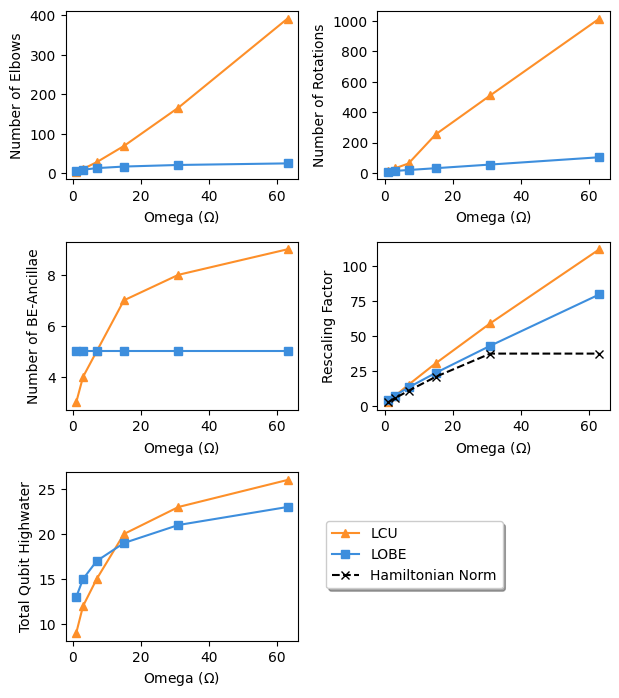

In [61]:
fig, axes = plt.subplots(3, 2, figsize=(16 / 2.54, 18 / 2.54))

axes[0][0].plot(omegas, [LCU_DATA[i][0].number_of_elbows for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[0][0].plot(omegas, [LOBE_DATA[i][0].number_of_elbows for i in range(len(omegas))], color=BLUE, marker='s', alpha = 1)
axes[0][0].set_ylabel("Number of Elbows")
axes[0][0].set_xlabel("Omega ($\Omega$)")

axes[0][1].plot(omegas, [LCU_DATA[i][0].number_of_rotations for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[0][1].plot(omegas, [LOBE_DATA[i][0].number_of_rotations for i in range(len(omegas))], color=BLUE, marker='s', alpha = 1)
axes[0][1].set_ylabel("Number of Rotations")
axes[0][1].set_xlabel("Omega ($\Omega$)")

axes[1][0].plot(omegas, [LCU_DATA[i][2] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[1][0].plot(omegas, [LOBE_DATA[i][2] for i in range(len(omegas))], color=BLUE, marker='s', alpha = 1)
axes[1][0].set_ylabel("Number of BE-Ancillae")
axes[1][0].set_xlabel("Omega ($\Omega$)")

axes[1][1].plot(omegas, [LCU_DATA[i][1] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[1][1].plot(omegas, [LOBE_DATA[i][1] for i in range(len(omegas))], color=BLUE, marker='s', alpha = 1)
axes[1][1].plot(omegas, [operator_norms[i] for i in range(len(omegas))], color="black", marker='x', ls='--', alpha = 1)
axes[1][1].set_ylabel("Rescaling Factor")
axes[1][1].set_xlabel("Omega ($\Omega$)")

axes[2][0].plot(omegas, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + system_qubits[i] + 1 for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1, label="LCU")
axes[2][0].plot(omegas, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + system_qubits[i] + 1 for i in range(len(omegas))], color=BLUE, marker='s', alpha = 1, label="LOBE")
axes[2][0].plot([], [], color="black", marker='x', ls='--', alpha = 1, label="Hamiltonian Norm")
axes[2][0].set_ylabel("Total Qubit Highwater")
axes[2][0].set_xlabel("Omega ($\Omega$)")

fig.delaxes(axes[2][1])
plt.tight_layout()
axes[2][0].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
          fancybox=True, shadow=True, ncol=1)
plt.savefig("../manuscript/figures/static_yukawa.pdf", dpi=300)